## Problem Statement

Wildlife conservationists and researchers need accurate predictions of animal movement patterns to prevent human-wildlife conflict, optimize conservation efforts, and track endangered species. The problem at hand is to build an LSTM (Long Short-Term Memory) model that leverages time-series sightings data to predict the spatial distribution of animal footprints. Specifically, the model will use five months of historical sightings data to generate a convex hull for each month's sightings, representing the estimated movement boundary of the animals. By analyzing these patterns over time, the model will then predict where animal footprints are most likely to appear in the sixth month. This approach aims to provide insights into wildlife movement, aiding conservation efforts and habitat monitoring.



### Import all modules

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
from folium.plugins import HeatMap

In [ ]:
!pip install folium geopandas branca

## The Dataset: Manually Created Using Domain Knowledge

Due to the unavailability of a dataset that aligns with the classification report from the Xception model, I manually created a dataset using domain knowledge to reflect lion movement patterns in Rwanda over the past six months. This dataset was designed based on seasonal climate variations and the assumption that areas surrounding Lake Kivu are designated as protected zones. By incorporating these factors, the dataset aims to provide a realistic representation of lion distribution and habitat preferences, ensuring that the model's outputs are grounded in ecological and environmental context.

In [ ]:
df = pd.read_csv('animal_sightings.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     350 non-null    object 
 1   latitude     350 non-null    float64
 2   longitude    350 non-null    float64
 3   month        350 non-null    object 
 4   season       350 non-null    object 
 5   temperature  350 non-null    float64
 6   humidity     350 non-null    float64
 7   wind_speed   350 non-null    float64
 8   pressure     350 non-null    float64
dtypes: float64(6), object(3)
memory usage: 24.7+ KB


,datetime,latitude,longitude,month,season,temperature,humidity,wind_speed,pressure
0,2024-08-28T04:00:27,-2.362276,29.209506,August,dry,29.448419,55.481629,1.459579,942.836281
1,2024-08-11T14:05:28,-2.304175,29.297499,August,dry,30.707020,46.870856,1.328231,962.274129
2,2024-08-03T04:05:29,-2.235072,29.210868,August,dry,27.552075,43.076368,1.617334,985.768244
3,2024-08-22T16:39:02,-2.260084,29.235988,August,dry,30.258844,35.406905,1.960843,923.315901
4,2024-08-24T20:49:54,-2.216869,29.238653,August,dry,27.720278,45.829497,3.456372,1014.617946


##Temporal Patterns

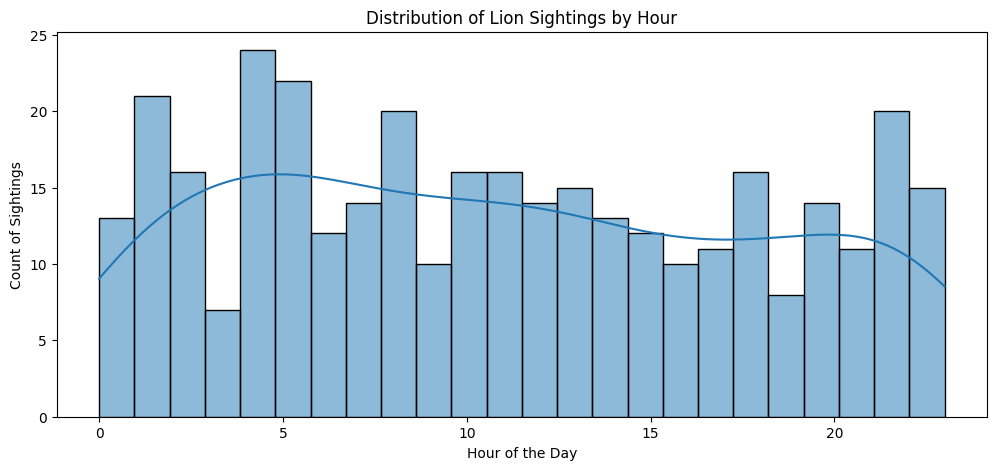

In [ ]:
df["datetime"] = pd.to_datetime(df["datetime"])
df["hour"] = df["datetime"].dt.hour
df["day"] = df["datetime"].dt.day
df["weekday"] = df["datetime"].dt.day_name()

# Check sighting frequency by time
plt.figure(figsize=(12, 5))
sns.histplot(df["hour"], bins=24, kde=True)
plt.xlabel("Hour of the Day")
plt.ylabel("Count of Sightings")
plt.title("Distribution of Lion Sightings by Hour")
plt.show()

The histogram displays the distribution of lion sightings by hour of the day. It reveals that sightings are most frequent during the early morning hours (midnight to 6 AM) and again in the late evening (around 8-10 PM). This suggests that lions are more active during these periods, possibly engaging in hunting or movement.

A noticeable dip occurs around midday and early afternoon (12-3 PM), where sightings decrease significantly. This decline could be attributed to lions resting during the hotter hours of the day, a common behavior among large predators in warm climates.

The smooth blue KDE (Kernel Density Estimation) line highlights the overall trend, showing an increase in sightings during the early morning, fluctuations throughout the day, and another peak in the evening. These insights can be useful for conservation efforts, as they indicate the best times for monitoring lions using patrols or camera traps.

In [ ]:
df

,datetime,latitude,longitude,month,season,temperature,humidity,wind_speed,pressure,hour,day,weekday
0,2024-08-28 04:00:27,-2.362276,29.209506,August,dry,29.448419,55.481629,1.459579,942.836281,4,28,Wednesday
1,2024-08-11 14:05:28,-2.304175,29.297499,August,dry,30.707020,46.870856,1.328231,962.274129,14,11,Sunday
2,2024-08-03 04:05:29,-2.235072,29.210868,August,dry,27.552075,43.076368,1.617334,985.768244,4,3,Saturday
3,2024-08-22 16:39:02,-2.260084,29.235988,August,dry,30.258844,35.406905,1.960843,923.315901,16,22,Thursday
4,2024-08-24 20:49:54,-2.216869,29.238653,August,dry,27.720278,45.829497,3.456372,1014.617946,20,24,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...
345,2025-02-25 14:33:59,-1.988442,29.406922,February,rainy,20.790336,83.948782,3.393802,970.168774,14,25,Tuesday
346,2025-02-02 23:13:32,-2.007372,29.392486,February,rainy,22.810570,71.281998,1.437670,948.880556,23,2,Sunday
347,2025-02-19 00:11:38,-2.017231,29.391546,February,rainy,15.696014,70.940735,3.762916,994.621512,0,19,Wednesday
348,2025-02-04 04:13:05,-2.013425,29.380630,February,rainy,19.597769,88.831433,2.669152,943.962649,4,4,Tuesday


## Geographic Distribution of Sightings

In [ ]:
import folium

# Create a map centered at the mean location
m = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=10)

# Add points to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color="red",
        fill=True,
        fill_color="red"
    ).add_to(m)

# Show the map
m

## Investigate Climate Factors

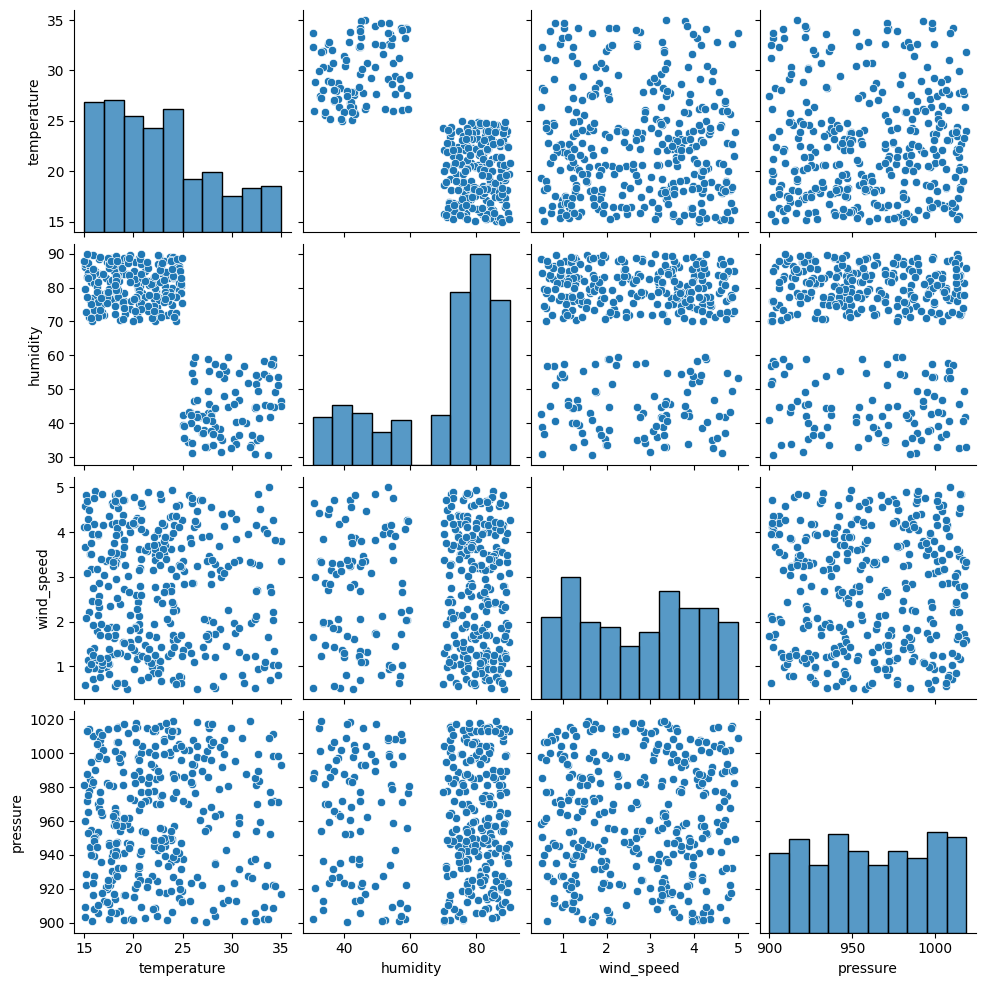

In [ ]:
sns.pairplot(df[["temperature", "humidity", "wind_speed", "pressure"]])
plt.show()

## Identify Seasonal Trends

<ipython-input-8-0eca13dd78e2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="month", y="temperature", data=df, palette="coolwarm")


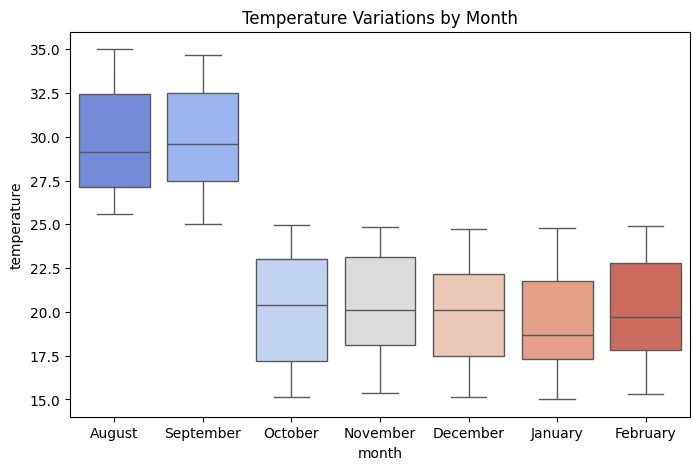

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="month", y="temperature", data=df, palette="coolwarm")
plt.title("Temperature Variations by Month")
plt.show()

In August and September, temperatures are notably higher, with medians around 30°C and a range extending from approximately 25°C to 35°C. These months experience the highest temperatures, suggesting they fall within the dry season.

From October to February, temperatures decrease significantly. The median temperature during these months hovers around 20-22°C, with lower and upper quartiles ranging between 15°C and 25°C. This shift suggests the transition into a cooler or wetter season.

The presence of whiskers in each month's box plot indicates variability, but no extreme outliers are visible, meaning temperature fluctuations remain within expected ranges.

This trend can provide valuable insights into seasonal changes affecting lion behavior. Higher temperatures in August and September could explain why sightings drop around midday, as lions may seek shade. Meanwhile, cooler temperatures in later months might influence their movement patterns differently.

## Explore Relationships Between Weather & Sightings

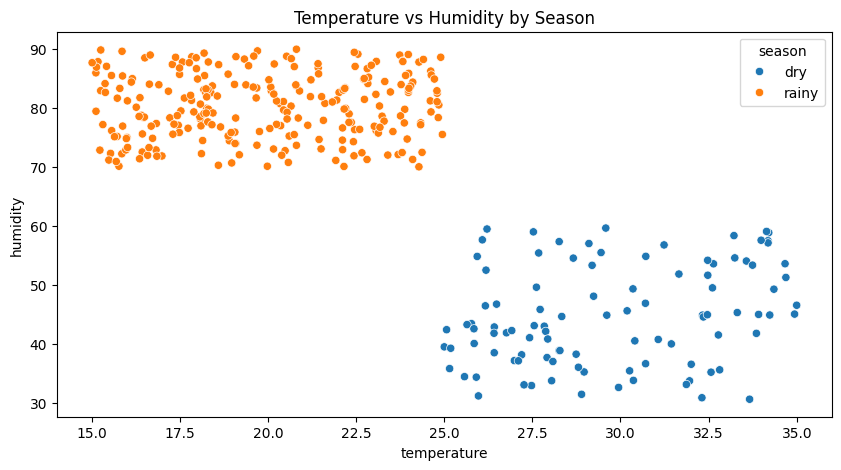

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x="temperature", y="humidity", hue="season", data=df)
plt.title("Temperature vs Humidity by Season")
plt.show()

This scatter plot visualizes the relationship between temperature and humidity, categorized by season (dry and rainy). Here’s what it shows:

**Two distinct clusters:**

- Rainy season (orange points): Located in the upper portion of the plot, indicating high humidity (70-90%) and lower temperatures (15-25°C).
- Dry season (blue points): Found in the lower portion of the plot, suggesting lower humidity (30-50%) and higher temperatures (25-35°C).

**Interpretation:**

- The rainy season is associated with cooler temperatures and high humidity.
- The dry season is characterized by hotter temperatures and lower humidity.

## Check Wind Speed & Pressure Impact

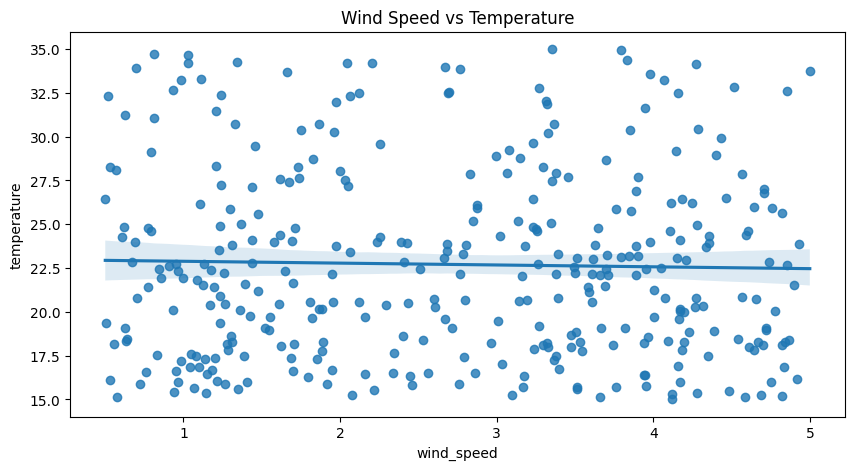

In [ ]:
plt.figure(figsize=(10, 5))
sns.regplot(x="wind_speed", y="temperature", data=df)
plt.title("Wind Speed vs Temperature")
plt.show()

### Observations:
1. **Spread of Data**:
   - **Wind speed** values range from approximately **0 to 5**.
   - **Temperature** values range from approximately **15 to 35°C**.
   - The data points are widely scattered, suggesting a **weak correlation**.

2. **Regression Line**:
   - The slight **upward slope** of the regression line suggests a very weak **positive correlation** between wind speed and temperature.
   - However, the **spread of data** around the regression line indicates **high variability**, meaning wind speed does not strongly predict temperature.

### Interpretation:
- Wind speed does not appear to have a **strong effect** on temperature, as the points are highly dispersed.
- The **trend is nearly flat**, indicating that temperature remains relatively **independent** of wind speed.

## Feature Engineering and Model Preparation

In [31]:
df = pd.read_csv('animal_sightings.csv')

## Cyclical Values

handling cyclical time-based data by transforming the hour and month values into sine and cosine components. Time-related features like hours and months are inherently cyclical, meaning they repeat in a periodic pattern.

In [32]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Cyclical Data
df = df.sort_values("datetime")
df["datetime"] = pd.to_datetime(df["datetime"])
df["month"] = df["datetime"].dt.month
df["hour"] = df["datetime"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

df

,datetime,latitude,longitude,month,season,temperature,humidity,wind_speed,pressure,hour,hour_sin,hour_cos,month_sin,month_cos
19,2024-08-01 22:06:31,-2.316373,29.257401,8,dry,30.717935,54.838988,3.368750,958.764524,22,-0.500000,0.866025,-0.866025,-0.5
37,2024-08-01 22:12:23,-2.285933,29.194049,8,dry,25.909561,34.330716,2.873504,981.877859,22,-0.500000,0.866025,-0.866025,-0.5
49,2024-08-02 04:35:01,-2.277269,29.238554,8,dry,29.237232,48.069492,3.077804,999.523735,4,0.866025,0.500000,-0.866025,-0.5
2,2024-08-03 04:05:29,-2.235072,29.210868,8,dry,27.552075,43.076368,1.617334,985.768244,4,0.866025,0.500000,-0.866025,-0.5
15,2024-08-06 00:53:13,-2.214715,29.222423,8,dry,25.773248,43.415118,3.858741,912.706806,0,0.000000,1.000000,-0.866025,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,2025-02-25 22:16:23,-1.992255,29.354193,2,rainy,17.767885,87.709111,3.545763,906.029034,22,-0.500000,0.866025,0.866025,0.5
331,2025-02-27 11:06:48,-1.985666,29.364897,2,rainy,16.345431,78.593868,3.172303,1005.350534,11,0.258819,-0.965926,0.866025,0.5
303,2025-02-27 14:31:11,-1.989242,29.371202,2,rainy,18.248825,79.162931,1.888203,942.337686,14,-0.500000,-0.866025,0.866025,0.5
341,2025-02-27 15:13:01,-2.031988,29.392992,2,rainy,20.808092,89.997447,4.275105,909.381719,15,-0.707107,-0.707107,0.866025,0.5


In [33]:
import folium
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from folium.plugins import MarkerCluster
from matplotlib import cm, colors

# Initialize a Folium map centered on Rwanda
m = folium.Map(location=[-1.5, 29.75], zoom_start=8)

# Define colors for different months using a colormap
cmap = cm.get_cmap("tab10", 12)
norm = colors.Normalize(vmin=1, vmax=12)
month_colors = {month: colors.to_hex(cmap(norm(month))) for month in df['month'].unique()}

# Add lion movement points
marker_cluster = MarkerCluster().add_to(m)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=month_colors[row['month']],
        fill=True,
        fill_color=month_colors[row['month']],
        fill_opacity=0.6,
    ).add_to(marker_cluster)

# Overlay convex hulls per month
for month in df['month'].unique():
    subset = df[df['month'] == month]
    points = subset[['latitude', 'longitude']].values  # Extract lat/lon

    if len(points) >= 3:  # Convex Hull requires at least 3 points
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        hull_polygon = [[lat, lon] for lat, lon in hull_points]
        hull_polygon.append(hull_polygon[0])  # Close the polygon

        folium.PolyLine(
            locations=hull_polygon,
            color=month_colors[month],
            weight=2.5,
            opacity=0.8,
            tooltip=f'Month {month}'
        ).add_to(m)

# Save and display the map
m.save("lion_movement_map.html")
m

<ipython-input-33-c99a9afbcc87>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", 12)


In [34]:
from scipy.spatial import ConvexHull
import numpy as np

# Group data by month and compute convex hulls
convex_hulls = {}
for month, group in df.groupby("month"):
    points = group[["latitude", "longitude"]].values
    hull = ConvexHull(points)
    convex_hulls[month] = points[hull.vertices]

## Feature Engineering

Adding a new feature called distance_to_water, calculated as the Euclidean distance between two points

In [35]:
lake_kivu_centroid = {"latitude": -1.984822, "longitude": 29.200500}

def calculate_distance_to_water(row, centroid):
    return np.sqrt(
        (row["latitude"] - centroid["latitude"])**2 +
        (row["longitude"] - centroid["longitude"])**2
    )

# Apply the function to each row in the DataFrame
df["distance_to_water"] = df.apply(
    lambda row: calculate_distance_to_water(row, lake_kivu_centroid),
    axis=1
)

df

,datetime,latitude,longitude,month,season,temperature,humidity,wind_speed,pressure,hour,hour_sin,hour_cos,month_sin,month_cos,distance_to_water
19,2024-08-01 22:06:31,-2.316373,29.257401,8,dry,30.717935,54.838988,3.368750,958.764524,22,-0.500000,0.866025,-0.866025,-0.5,0.336398
37,2024-08-01 22:12:23,-2.285933,29.194049,8,dry,25.909561,34.330716,2.873504,981.877859,22,-0.500000,0.866025,-0.866025,-0.5,0.301181
49,2024-08-02 04:35:01,-2.277269,29.238554,8,dry,29.237232,48.069492,3.077804,999.523735,4,0.866025,0.500000,-0.866025,-0.5,0.294912
2,2024-08-03 04:05:29,-2.235072,29.210868,8,dry,27.552075,43.076368,1.617334,985.768244,4,0.866025,0.500000,-0.866025,-0.5,0.250465
15,2024-08-06 00:53:13,-2.214715,29.222423,8,dry,25.773248,43.415118,3.858741,912.706806,0,0.000000,1.000000,-0.866025,-0.5,0.230935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,2025-02-25 22:16:23,-1.992255,29.354193,2,rainy,17.767885,87.709111,3.545763,906.029034,22,-0.500000,0.866025,0.866025,0.5,0.153873
331,2025-02-27 11:06:48,-1.985666,29.364897,2,rainy,16.345431,78.593868,3.172303,1005.350534,11,0.258819,-0.965926,0.866025,0.5,0.164399
303,2025-02-27 14:31:11,-1.989242,29.371202,2,rainy,18.248825,79.162931,1.888203,942.337686,14,-0.500000,-0.866025,0.866025,0.5,0.170759
341,2025-02-27 15:13:01,-2.031988,29.392992,2,rainy,20.808092,89.997447,4.275105,909.381719,15,-0.707107,-0.707107,0.866025,0.5,0.198187


## Normalize data

In [36]:
from sklearn.preprocessing import MinMaxScaler

# Select columns to normalize
num_cols = ['temperature', 'humidity', 'wind_speed', 'pressure', 'hour_sin', 'hour_cos',
            'month_sin', 'month_cos', 'distance_to_water']

scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize selected columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [37]:
df = df.sort_values(by=['datetime'])

In [38]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
season_encoded = encoder.fit_transform(df[["season"]])

df = df.drop(columns=["season"])
df[encoder.get_feature_names_out(["season"])] = season_encoded

df

,datetime,latitude,longitude,month,temperature,humidity,wind_speed,pressure,hour,hour_sin,hour_cos,month_sin,month_cos,distance_to_water,season_dry,season_rainy
19,2024-08-01 22:06:31,-2.316373,29.257401,8,0.785868,0.408231,0.637533,0.493186,22,0.250000,0.933013,0.071797,0.000000,0.623690,1.0,0.0
37,2024-08-01 22:12:23,-2.285933,29.194049,8,0.545261,0.063046,0.527456,0.687523,22,0.250000,0.933013,0.071797,0.000000,0.507128,1.0,0.0
49,2024-08-02 04:35:01,-2.277269,29.238554,8,0.711775,0.294290,0.572865,0.835889,4,0.933013,0.750000,0.071797,0.000000,0.486382,1.0,0.0
2,2024-08-03 04:05:29,-2.235072,29.210868,8,0.627451,0.210248,0.248253,0.720233,4,0.933013,0.750000,0.071797,0.000000,0.339270,1.0,0.0
15,2024-08-06 00:53:13,-2.214715,29.222423,8,0.538440,0.215950,0.746441,0.105932,0,0.500000,1.000000,0.071797,0.000000,0.274632,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,2025-02-25 22:16:23,-1.992255,29.354193,2,0.137858,0.961484,0.676877,0.049785,22,0.250000,0.933013,1.000000,0.666667,0.019572,0.0,1.0
331,2025-02-27 11:06:48,-1.985666,29.364897,2,0.066679,0.808061,0.593869,0.884881,11,0.629410,0.017037,1.000000,0.666667,0.054412,0.0,1.0
303,2025-02-27 14:31:11,-1.989242,29.371202,2,0.161923,0.817639,0.308458,0.355069,14,0.250000,0.066987,1.000000,0.666667,0.075463,0.0,1.0
341,2025-02-27 15:13:01,-2.031988,29.392992,2,0.289987,1.000000,0.838984,0.077975,15,0.146447,0.146447,1.000000,0.666667,0.166241,0.0,1.0


In [39]:
df = df.drop(columns=['datetime', 'month', 'hour'])

## LSTM Sequence: Using 5 month's worth of data to predict the 6th month

In [ ]:
def create_sequences(df, sequence_length=5):
    X, Y = [], []

    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length][num_cols].values)  # Features from past 5 months
        Y.append(df.iloc[i+sequence_length][['latitude', 'longitude']].values)  # Target month location

    return np.array(X), np.array(Y)

sequence_length = 5
X, Y = create_sequences(df, sequence_length)

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Normalize latitude & longitude separately
lat_lon_scaler = MinMaxScaler()
y_train = lat_lon_scaler.fit_transform(y_train)
y_test = lat_lon_scaler.transform(y_test)

In [40]:
# chat

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def create_sequences(df, sequence_length=5):
    X, Y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length][num_cols].values)  # Features from past 5 months
        Y.append(df.iloc[i+sequence_length][['latitude', 'longitude']].values)  # Target month location
    return np.array(X), np.array(Y)

sequence_length = 5
X, Y = create_sequences(df, sequence_length)

# Define the split indices
train_size = int(0.8 * (len(X) - 1))  # 80% for training, excluding the last test month
val_size = int(0.1 * (len(X) - train_size))  # 10% for validation (from end of training)

# Split the data
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = Y[:train_size], Y[train_size:train_size+val_size], Y[train_size+val_size:]

# Normalize latitude & longitude separately
lat_lon_scaler = MinMaxScaler()
y_train = lat_lon_scaler.fit_transform(y_train)
y_val = lat_lon_scaler.transform(y_val)
y_test = lat_lon_scaler.transform(y_test)  # Keep test scaling consistent with training


# LSTM Model

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(5, 9)),  # 5 months input
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2)  # Latitude & Longitude
])

# Include metrics when compiling the model.
model.compile(optimizer='adam', loss='mse', metrics=['mae']) # metrics=['mae'] added
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 5, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,210 (477.38 KB)

 Trainable params: 122,210 (477.38 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
X_train

array([[[0.78586777, 0.40823051, 0.63753277, ..., 0.07179677,
         0.        , 0.62368979],
        [0.54526055, 0.06304558, 0.52745638, ..., 0.07179677,
         0.        , 0.50712809],
        [0.71177458, 0.29428975, 0.57286526, ..., 0.07179677,
         0.        , 0.48638166],
        [0.62745067, 0.210248  , 0.24825294, ..., 0.07179677,
         0.        , 0.33926983],
        [0.5384396 , 0.21594968, 0.74644085, ..., 0.07179677,
         0.        , 0.27463237]],

       [[0.54526055, 0.06304558, 0.52745638, ..., 0.07179677,
         0.        , 0.50712809],
        [0.71177458, 0.29428975, 0.57286526, ..., 0.07179677,
         0.        , 0.48638166],
        [0.62745067, 0.210248  , 0.24825294, ..., 0.07179677,
         0.        , 0.33926983],
        [0.5384396 , 0.21594968, 0.74644085, ..., 0.07179677,
         0.        , 0.27463237],
        [0.86633889, 0.24017746, 0.34768671, ..., 0.07179677,
         0.        , 0.35834251]],

       [[0.71177458, 0.29428975, 0.5

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1480 - mae: 0.3173 - val_loss: 0.0908 - val_mae: 0.2505
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0507 - mae: 0.1787 - val_loss: 0.0292 - val_mae: 0.1505
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0354 - mae: 0.1468 - val_loss: 0.0097 - val_mae: 0.0767
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0272 - mae: 0.1303 - val_loss: 0.0158 - val_mae: 0.1123
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0264 - mae: 0.1247 - val_loss: 0.0113 - val_mae: 0.0961
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0253 - mae: 0.1238 - val_loss: 0.0080 - val_mae: 0.0771
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0254 - mae: 0.1251 - val_loss: 0.0091 - val_mae: 0.0863
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0255 - mae: 0.1276 - val_loss: 0.0127 - val_mae: 0.0862
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0292 - 

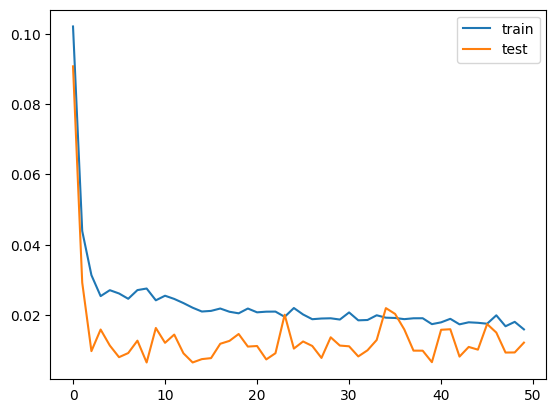

In [43]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

#plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [44]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0242 - mae: 0.1277
Test MAE: 0.1307


In [45]:
predictions = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


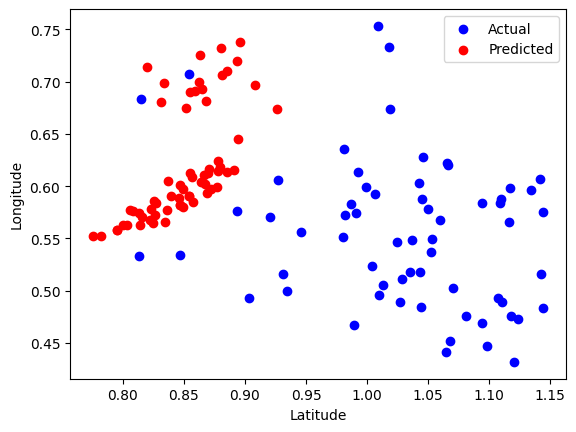

In [46]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.scatter(y_test[:, 0], y_test[:, 1], color='blue', label="Actual")
plt.scatter(y_pred[:, 0], y_pred[:, 1], color='red', label="Predicted")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend()
plt.show()

In [47]:
# save model
model.save('lion_movement_model.h5')